Computes the SMAE for a standard Gaussian process 

In [1]:
import torch
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from botorch.models import SingleTaskGP
import gpytorch as gpt
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll,fit_gpytorch_mll_torch
from gpytorch.models import ExactGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.functions import MaternCovariance
from torch.optim import Adam
from mpl_toolkits.mplot3d import axes3d, Axes3D

/home/sutirthapaul/miniconda3/envs/benzenetest2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.rcParams["figure.figsize"] = [3.4039, 2.10373]

In [4]:
V = np.load('../data/HeBz/all_pts_2545.npy')

In [5]:
x = np.array([])
y = np.array([])
z = np.array([])
data_points = []
Pot = np.array([])
Pot_diff = np.array([])
for array in V:

    x = np.append(x,array[0])
    y = np.append(y,array[1])
    z = np.append(z,array[2])
    data_points.append([array[0],array[1],array[2]])
    Pot = np.append(Pot,array[3])

In [6]:
#Create training data
torch.manual_seed(0)
#X_train = torch.from_numpy(np.array(training_points))
#Y_train = torch.from_numpy(np.array(training_values)).unsqueeze(-1)

X_train = torch.from_numpy(np.array(data_points))
Y_train = torch.from_numpy(np.array(Pot)).unsqueeze(-1)
Y_train_trunc = Y_train[Y_train[:, 0]<=1000]
X_train_trunc = X_train[Y_train[:, 0]<=1000, :]
X_train= X_train_trunc
Y_train = Y_train_trunc

In [7]:
mixed_covar = gpt.kernels.ScaleKernel(gpt.kernels.MaternKernel(nu=1.5,ard_num_dims=X_train.shape[-1]))

In [8]:
xplt = np.array([])
yplt = np.array([])
zplt = np.array([])
cplt = np.array([])
for i in range(len(X_train)):
    xplt = np.append(xplt,X_train[i][0].numpy())
    yplt = np.append(yplt,X_train[i][1].numpy())
    zplt = np.append(zplt,X_train[i][2].numpy())
    cplt = np.append(cplt,Y_train[i][0].numpy())

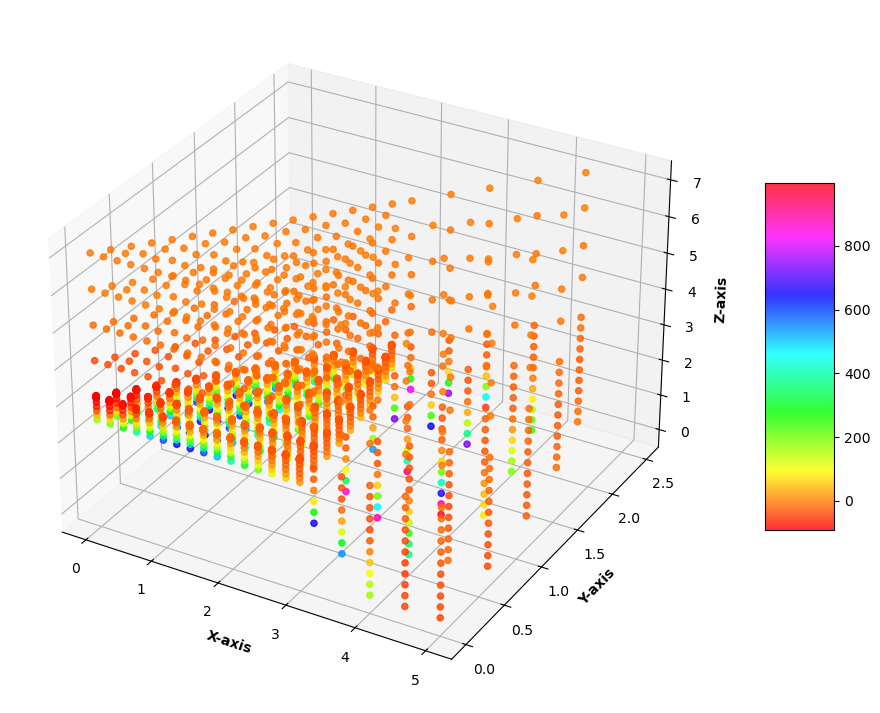

In [9]:
# Creating figure

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

# Color map
my_cmap = plt.get_cmap('hsv')

# Create plot
sctt = ax.scatter3D(xplt, yplt, zplt, c=cplt, cmap=my_cmap, alpha=0.8)

ax.set_xlabel('X-axis', fontweight='bold')
ax.set_ylabel('Y-axis', fontweight='bold')
ax.set_zlabel('Z-axis', fontweight='bold')

fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)

plt.show()
#plt.savefig('All-points.pdf')

In [11]:
#Pick random indices
n = int(0.8*(X_train.shape[0])) 
test_data = []
test_chisquared = []
test_error = []
test_set_CC = []
test_set_GP = []
test_error_mean = []
test_error_rel = []
for i in range(1,10):
    print(i)
    rng1 = np.random.default_rng(i)
    index = np.random.choice(X_train.shape[0], n, replace=False)
    complement = np.delete(np.arange(X_train.shape[0]), index)
    X_train_random = X_train[index]
    Y_train_random = Y_train[index]
    data_eval = X_train[complement]
    correct_pot = Y_train[complement]
    for j in data_eval:
        test_data.append(j.numpy())
    print(len(test_data))
    
    #Train-the-data
    
    gp_model = SingleTaskGP(train_X=X_train_random, train_Y=Y_train_random, input_transform=Normalize(d=3),outcome_transform=Standardize(m=1), covar_module=mixed_covar)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    
    # Fit the model hyperparameters
    #optimizer = Adam([{'params': gp_model.parameters()}], lr=0.01,weight_decay=0.01)
    #fit_gpytorch_mll(mll)
    with torch.no_grad():
        posterior = gp_model.posterior(data_eval)
        mean = posterior.mean
        variance = posterior.variance
    """
    GP_fit = np.zeros(len(mean))
    for k in range(len(GP_fit)):
        GP_fit[k] = mean[k] + Vfit(data_eval[k][0], data_eval[k][1],data_eval[k][2])
    """
    #interpolantLin = interp.RBFInterpolator(X_train_random.numpy(),Y_train_random.numpy())
    fit = mean.numpy()
    #print(correct_pot.numpy())
    #print(fit)
    abs_error = np.abs(correct_pot.numpy() - fit)
    #print(abs_error)
    abs_error = np.array(abs_error).flatten()
    #print(abs_error)
    chisquared = (abs_error)**2
    for i in range(len(fit)):
        test_chisquared.append(chisquared[i])
        test_error.append(abs_error[i])
        test_set_CC.append(correct_pot.numpy().flatten()[i])
        test_set_GP.append(fit.flatten()[i])
        test_error_rel.append(abs_error[i]/correct_pot[i].numpy()[0])
    #print(len(test_chisquared))
    print(len(test_error))
    test_error_mean.append(np.mean(abs_error))
    #print(len(test_error_rel))
    #relative_err = ((V_fit_arr(data_eval) - posterior.mean.numpy())/V_fit_arr(data_eval))

1
505
505
2
1010
1010
3
1515
1515
4
2020
2020
5
2525
2525
6
3030
3030
7
3535
3535
8
4040
4040
9
4545
4545


In [12]:
np.save('../data/STGPCC.npy', np.array(test_set_CC))
np.save('../data/STGPGP.npy', np.array(test_set_GP))